In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# tes mfcc satu sampel audio

# import librosa
# import numpy as np

# # Muat file audio
# audio_path = 'drive/MyDrive/genres_original/blues/blues.00002.wav'
# y, sr = librosa.load(audio_path, sr=None)

# # Setel parameter MFCC
# n_mfcc = 13  # Jumlah koefisien MFCC yang ingin diekstraksi
# hop_length = 512  # Jarak antara frame
# n_fft = 2048  # Ukuran FFT (biasanya dua kali hop_length)

# # Ekstraksi MFCC
# mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

# print(mfccs.shape)  # Output: (n_mfcc, jumlah frame)

(13, 1293)


In [ ]:
import os
import pandas as pd
import librosa
import numpy as np

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13, hop_length=512, n_fft=2048):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return mfccs

# Menyimpan path, mood, mfcc
df = pd.DataFrame(columns=["path", "mood_label", "mfcc"])

drive_path = 'drive/MyDrive/genres_original'

folders = os.listdir(drive_path)
for f in folders:
    emotion_path = os.path.join(drive_path, f)
    files = os.listdir(emotion_path)
    for data in files:
        file_path = os.path.join(emotion_path, data)
        mfcc = extract_mfcc(file_path)
        df = pd.concat([df, pd.DataFrame({"path": [file_path], "mood_label": [f], "mfcc": [mfcc]})], ignore_index=True)

print(df.head())

df.to_csv('mfcc-library-genre.csv')

                                                path mood_label  \
0  drive/MyDrive/genres_original/metal/metal.0000...      metal   
1  drive/MyDrive/genres_original/metal/metal.0000...      metal   
2  drive/MyDrive/genres_original/metal/metal.0000...      metal   
3  drive/MyDrive/genres_original/metal/metal.0000...      metal   
4  drive/MyDrive/genres_original/metal/metal.0000...      metal   

                                                mfcc  
0  [[-58.96375, -31.190329, -32.98419, -33.70692,...  
1  [[-142.57224, -110.645424, -110.086586, -112.0...  
2  [[-92.42695, -68.25919, -69.20889, -68.00151, ...  
3  [[-129.27205, -111.480576, -106.21667, -74.432...  
4  [[-67.56934, -26.87084, -29.88016, -44.382046,...  


In [ ]:
# df = pd.read_csv('mfcc-library-genre.csv')

In [ ]:
import pandas as pd
df.head()

,path,mood_label,mfcc
0,drive/MyDrive/genres_original/metal/metal.0000...,metal,"[[-58.96375, -31.190329, -32.98419, -33.70692,..."
1,drive/MyDrive/genres_original/metal/metal.0000...,metal,"[[-142.57224, -110.645424, -110.086586, -112.0..."
2,drive/MyDrive/genres_original/metal/metal.0000...,metal,"[[-92.42695, -68.25919, -69.20889, -68.00151, ..."
3,drive/MyDrive/genres_original/metal/metal.0000...,metal,"[[-129.27205, -111.480576, -106.21667, -74.432..."
4,drive/MyDrive/genres_original/metal/metal.0000...,metal,"[[-67.56934, -26.87084, -29.88016, -44.382046,..."


In [ ]:
mfcc = df["mfcc"]
label = df["mood_label"]

In [ ]:
mfcc = np.array(mfcc)

In [ ]:
mfcc.shape

(999,)

In [ ]:
import numpy as np

# tentukan panjang mmaksimum sampel dari semua sampel mfcc
max_length = max(sample.shape[1] for sample in mfcc)

padded_mfcc = []
for sample in mfcc:

    #pad_width dihitung = selisih max_length dengan panjang frame saat ini
    pad_width = max_length - sample.shape[1]

    # Menyusun seluruh frame yang sudah dipadding ke dalam satu array
    padded_sample = np.pad(sample, ((0, 0), (0, pad_width)), mode='constant')

    # menambahkan dimensi baru di akhir untuk memenuhi format input
    padded_mfcc.append(padded_sample[:, :, np.newaxis])

data = np.stack(padded_mfcc)

print(data.shape) # (999, 13, max_frame, 1)


(999, 13, 1320, 1)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU, SpatialDropout2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2

# parameter input
num_rows = 13
num_columns = 1320
num_channels = 1
num_labels = 10

def create_model(spatial_dropout_rate_1=0.07, spatial_dropout_rate_2=0.14, l2_rate=0.0005):
    model = Sequential()

    # Conv 1
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     kernel_regularizer=l2(l2_rate),
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(spatial_dropout_rate_1))

    # Conv 2
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 3
    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    # Conv 4
    # model.add(SpatialDropout2D(spatial_dropout_rate_2))
    # model.add(Conv2D(filters=64,
    #                  kernel_size=(3, 3),
    #                  kernel_regularizer=l2(l2_rate)))
    # model.add(LeakyReLU(alpha=0.1))
    # model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    # Dense (Softmax output)
    model.add(Dense(num_labels, activation='softmax'))

    return model

model = create_model()


In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

NUM_CLASSES = y_test_encoded.shape[1]

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.optimizers.legacy import Adam

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold_no} ...")

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    model = create_model()
    opt = Adam(0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

print('Average scores  5-folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Training fold 1 ...
Epoch 1/100
20/20 [==============================] - 7s 95ms/step - loss: 2.0158 - accuracy: 0.2958 - val_loss: 2.9589 - val_accuracy: 0.2000
Epoch 2/100
20/20 [==============================] - 1s 43ms/step - loss: 1.6603 - accuracy: 0.4382 - val_loss: 3.0526 - val_accuracy: 0.1562
Epoch 3/100
20/20 [==============================] - 1s 44ms/step - loss: 1.4979 - accuracy: 0.5039 - val_loss: 2.5115 - val_accuracy: 0.2188
Epoch 4/100
20/20 [==============================] - 1s 44ms/step - loss: 1.3962 - accuracy: 0.5462 - val_loss: 2.2083 - val_accuracy: 0.2688
Epoch 5/100
20/20 [==============================] - 1s 47ms/step - loss: 1.3115 - accuracy: 0.5759 - val_loss: 1.9086 - val_accuracy: 0.2937
Epoch 6/100
20/20 [==============================] - 1s 52ms/step - loss: 1.2386 - accuracy: 0.5759 - val_loss: 1.7237 - val_accuracy: 0.3500
Epoch 7/100
20/20 [==============================] - 1s 60ms/step - loss: 1.2167 - accuracy: 0.6088 - val_loss: 1.4060 - val_acc

7/7 [==============================] - 0s 50ms/step


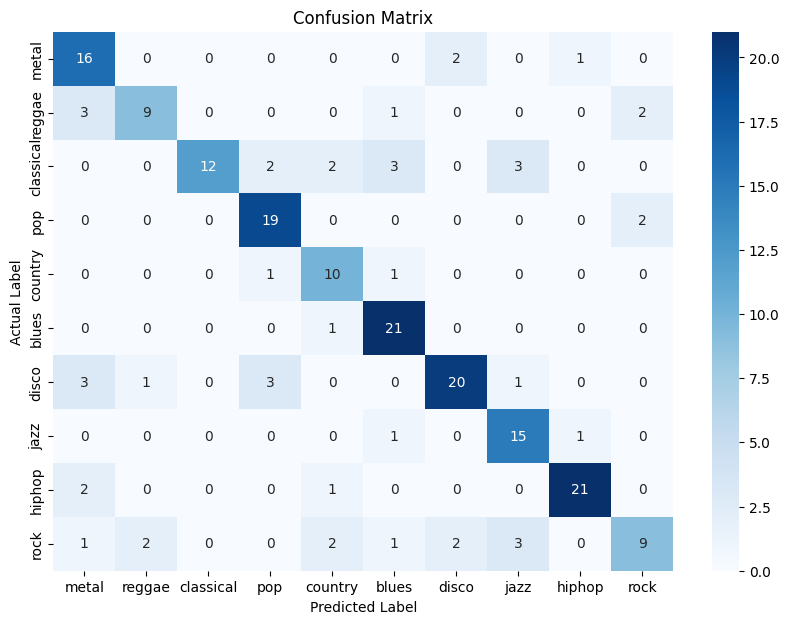

Accuracy Score: 0.76
Classification Report:
               precision    recall  f1-score   support

       metal       0.64      0.84      0.73        19
      reggae       0.75      0.60      0.67        15
   classical       1.00      0.55      0.71        22
         pop       0.76      0.90      0.83        21
     country       0.62      0.83      0.71        12
       blues       0.75      0.95      0.84        22
       disco       0.83      0.71      0.77        28
        jazz       0.68      0.88      0.77        17
      hiphop       0.91      0.88      0.89        24
        rock       0.69      0.45      0.55        20

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.78      0.76      0.75       200



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# genre label
genres = np.array(['metal', 'reggae', 'classical', 'pop', 'country', 'blues', 'disco', 'jazz', 'hiphop', 'rock'])

# prediksi peluang setiap label
y_pred_probs = model.predict(X_test)

# konversi probabilitas ke dalam label single class
y_pred = genres[np.argmax(y_pred_probs, axis=-1)]
y_test_single = genres[np.argmax(y_test_encoded, axis=-1)]

# cmatrix
cm = confusion_matrix(y_test_single, y_pred)

# plot cmatrix dengan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy Score:", accuracy_score(y_test_single, y_pred))
print("Classification Report:\n", classification_report(y_test_single, y_pred, target_names=genres))


In [ ]:
model.save("mfcc-cnn-genre.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
